In [50]:
#general import
import os
import numpy as np
import pandas as pd

#nn import
from torch import device, load

#stats import
from scipy.stats import ttest_rel, wilcoxon
from statistics import median

#general visualization import
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import gridspec, colors, colormaps

#brain visualization import
from nilearn import regions, maskers, datasets, surface, plotting, image
from nilearn.plotting import plot_roi, plot_stat_map
from nilearn.maskers import NiftiMasker

#package import (for class) --> TO CHANGE
import sys
sys.path.append('/home/maelle/GitHub_repositories/cNeuromod_encoding_2020')  
import models

In [2]:
out_path = '/home/maelle/Results/figures/surface'
r2_test_model_path = '/home/maelle/Results/best_models'
r2_by_run_path = '/home/maelle/Results/best_models/predict_S4_runs'
MIST_path = '/home/maelle/DataBase/fMRI_parcellations/MIST_parcellation/Parcellations/MIST_ROI.nii.gz'
voxel_mask = '/home/maelle/GitHub_repositories/cNeuromod_encoding_2020/parcellation/STG_middle.nii.gz'
mist_roi_labels = '/home/maelle/DataBase/fMRI_parcellations/MIST_parcellation/Parcel_Information/MIST_ROI.csv'

label_pd = pd.read_csv(mist_roi_labels, sep=';')
print(label_pd.columns)

subs = ['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-05', 'sub-06']
scale = 'MIST_ROI' #'auditory_Voxels'   
conv = 'conv4'
baseline = 'no_ft'
null_model = 'no_init'
diff_name = '{}-{}'.format(conv, baseline)

colormap = {
    'right_SUPERIOR_TEMPORAL_GYRUS_middle':'maroon',
    'left_SUPERIOR_TEMPORAL_GYRUS_middle':'indianred',
    'right_SUPERIOR_TEMPORAL_GYRUS_posterior':'orange',
    'left_SUPERIOR_TEMPORAL_GYRUS_posterior':'navajowhite',
    'right_MIDDLE_TEMPORAL_GYRUS_posterior':'goldenrod',
    'left_MIDDLE_TEMPORAL_GYRUS_posterior':'gold',
    'right_HESCHLS GYRUS':'seagreen',
    'left_HESCHLS GYRUS':'darkseagreen',
    'right_VENTRAL_VISUAL_NETWORK_lateral':'darkblue',
    'left_POSTERIOR_VISUAL_NETWORK_lateral':'mediumslateblue',
    'right_LATERAL_VISUAL_NETWORK_dorsoposterior':'darkmagenta',
    'left_LATERAL_VISUAL_NETWORK_dorsoposterior':'palevioletred',
}

Index(['roi', 'label', 'name', 'size', 'symmetry', 'laterality', 'x', 'y', 'z',
       'neighbour', 'parent', 'overlap'],
      dtype='object')


In [3]:
def list_positions_in_matrix2D(nb_rows, nb_col):
    i_rows = np.repeat(np.arange(nb_rows), nb_col)
    i_col = np.tile(np.arange(nb_col), nb_rows)
    pos = [(row, col) for row, col in zip(i_rows, i_col)]
    return pos

In [4]:
def sum_conditions(conditions) : 
    correct = True
    for condition in conditions:
        if condition == False:
            correct = False
            break
    return correct

In [5]:
def get_specific_file_path(path, *cond):
    specific_file_path = None
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        conditions = [(obj in file) if boolean else (obj not in file) for (obj, boolean) in cond]
        specific_file = sum_conditions(conditions)
        specific_file_path = filepath if specific_file else specific_file_path
    return specific_file_path

In [6]:
def df_runs_from_n_best_roi(data, n, columns_label = label_pd['name']):
    runs_df = pd.DataFrame(data, columns=columns_label)  
    median_runs_df = runs_df.median().sort_values(ascending=False)
    best_n_roi = list(median_runs_df.head(n).index)

    all_runs_df = runs_df.melt(var_name = 'roi', value_name='r2')
    best_runs = all_runs_df.loc[(all_runs_df['roi'].isin(best_n_roi))].copy()
    best_runs['subject'] = sub

    return (best_n_roi, best_runs)

In [7]:
def voxels_nii(voxel_data, voxel_mask, t_r=1.49):
#from voxels to nii
    voxel_masker = maskers.NiftiMasker(mask_img=voxel_mask, standardize=False, 
                                       detrend=False, t_r=t_r, smoothing_fwhm=8)
    voxel_masker.fit()
    vox_data_nii = voxel_masker.inverse_transform(voxel_data)
    return vox_data_nii

In [8]:
def brain_with_cuts(axe = 'sagittal', axe_slice = 50, cut_x = [], cut_y = [], cut_z = [], ax=None):
    brain = datasets.load_mni152_template()
    brain_arr = image.get_data(brain)
    
    #select the array
    if axe == 'x' or axe == 'sagittal':
        brain_slice = brain_arr[axe_slice,:,:].squeeze()
        cuts = [cut_y, cut_z]
    elif axe == 'y' or axe == 'coronal':
        brain_slice = brain_arr[:,axe_slice,:].squeeze()
        cuts = [cut_x, cut_z]
    elif axe == 'z' or axe == 'axial':
        brain_slice = brain_arr[:,:,axe_slice].squeeze()
        cuts = [cut_x, cut_y]
    else : 
        raise ValueError('the axe of the brain slice {} does not exist'.format(axe))
    
    #remove noise + black background
    brain_slice[brain_slice < 10**-10] = 0
    brain_slice[brain_slice == 0.0] = 1
    
    #add the cut in the array
    for cut in cuts[0] : 
        brain_slice[cut, :] = 0
    for cut in cuts[1] : 
        brain_slice[:, cut] = 0
    
    brain_slice = np.flip(brain_slice.T, axis=0)
    
    if ax is not None:
        ax.imshow(brain_slice, cmap='gray')
    else : 
        plt.imshow(brain_slice, cmap='gray')

In [9]:
def voxel_map(voxel_data, vmax=None, cut_coords=None, tr = 1.49) : 
    f = plt.Figure()
    data_nii = voxels_nii(voxel_data, voxel_mask, t_r=tr)
    plotting.plot_stat_map(data_nii, draw_cross=False, vmax=vmax,
                           display_mode='x', cut_coords=[-63, -57, 57, 63], figure=f)
    return f

In [10]:
def striplot_with_median(data, x, y, hue, hue_order, palette, ax):
    sns.stripplot(data = data, x=x, y=y, hue = hue, hue_order = hue_order, palette=palette,
                  dodge = True, jitter = True, alpha=0.2, ax=ax)
    sns.pointplot(data = data, x=x, y=y, hue = hue, hue_order = hue_order, palette=palette,
                  estimator=median, join = False, errorbar=None, errwidth=0, markers='D', ax=ax,
                  scale=0.75, dodge = .8 - .8 / 7)
    ax.set_ylim(-0.4, 0.6)
    ax.legend([])
    ax.hlines(y=0, xmin = -0.4, xmax = 0.4, linewidth=1, color='grey', linestyles='dotted')
    
    markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in palette.values()]
    legend_ax.legend(markers, palette.keys(), numpoints=1, bbox_to_anchor=(1,1))
    legend_ax.set_axis_off()

In [11]:
def surface_fig(parcel_data, vmax, threshold=0.05, cmap='turbo', inflate=True, colorbar=True):
    nii_data = regions.signals_to_img_labels(parcel_data, MIST_path)
    fig, ax = plotting.plot_img_on_surf(nii_data,
                              views=['lateral', 'medial'], hemispheres=['left', 'right'], inflate=inflate,
                              vmax=vmax, threshold=threshold, colorbar=colorbar, cmap=cmap, symmetric_cbar=False)
    return fig

In [12]:
def stats_between_pop(pop1, pop2, test = ttest_rel, threshold = 0.05, difference=False):
    sign_diff_rois = []
    for i, (pop1_roi, pop2_roi) in enumerate(zip(pop1, pop2)):
        if difference :
            pop1_roi = pop1_roi - pop2_roi
            pop2_roi = None
        stat, pvalue = test(pop1_roi, pop2_roi)
        if pvalue <= threshold :
            sign_diff_rois.append((i, pvalue))
    return sign_diff_rois

In [13]:
def best_rois_in_MIST_array(data_array, nb_occ=3):
    a = np.unique(np.argmax(data_array, axis=1), return_counts=True)
    nb_i = [(i, nb, label_pd['label'].iloc[i]) for i, nb in zip(a[0], a[1]) if nb>=nb_occ]
    return nb_i

In [53]:
def extend_colormap(original_colormap = 'twilight', percent_start = 0.25, percent_finish = 0.25):
    colormap = colormaps[original_colormap]
    nb_colors = len(colormap.colors)
    new_colors_range = colormap(np.linspace(0,1,nb_colors))

    n_start = round(nb_colors/(1-percent_start)) - nb_colors if percent_start != 0 else 0
    new_color_start = np.array([colormap(0)]*n_start).reshape(-1, new_colors_range.shape[1])
    n_finish = round(nb_colors/(1-percent_finish)) - nb_colors if percent_finish != 0 else 0
    new_color_finish = np.array([colormap(0)]*n_finish).reshape(-1, new_colors_range.shape[1])

    new_colors_range = np.concatenate((new_color_start,new_colors_range,new_color_finish), axis=0)
    new_colormap = colors.ListedColormap(new_colors_range)
    return new_colormap

sub-01
131
sub-02
128
sub-03
141
sub-04
149
sub-05
120
sub-06
150


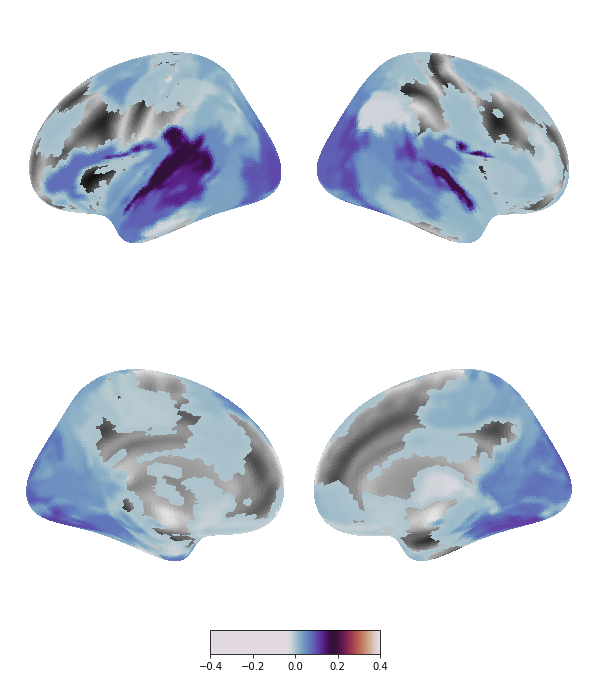

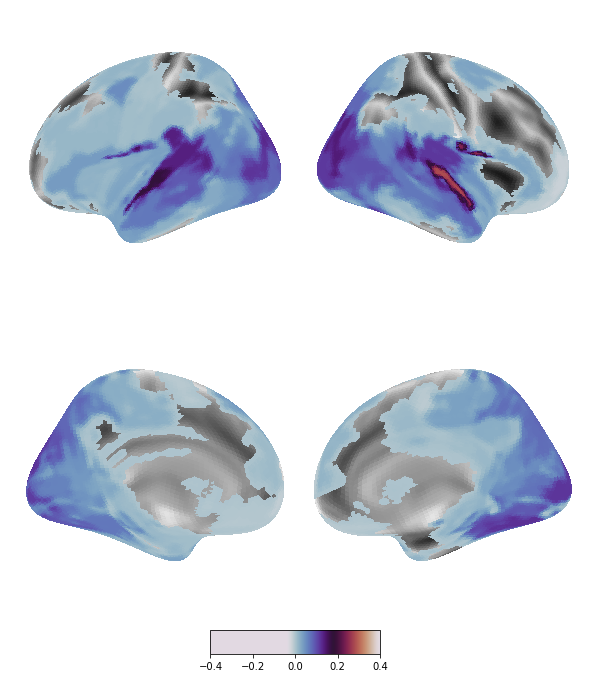

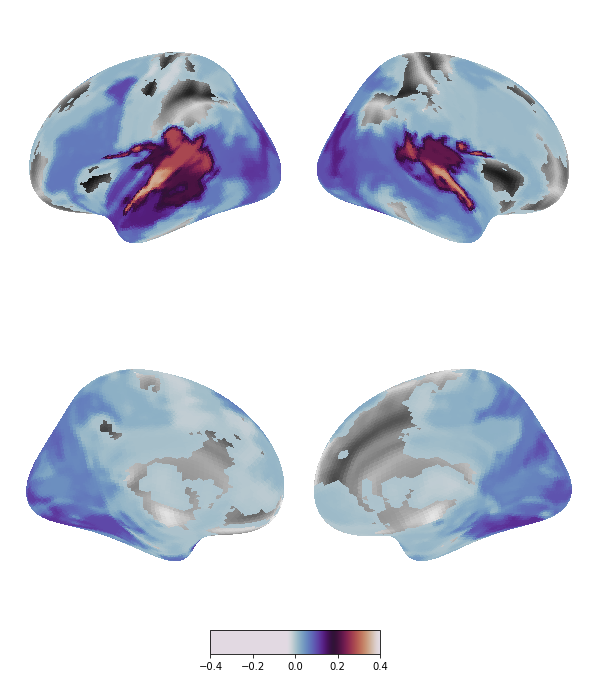

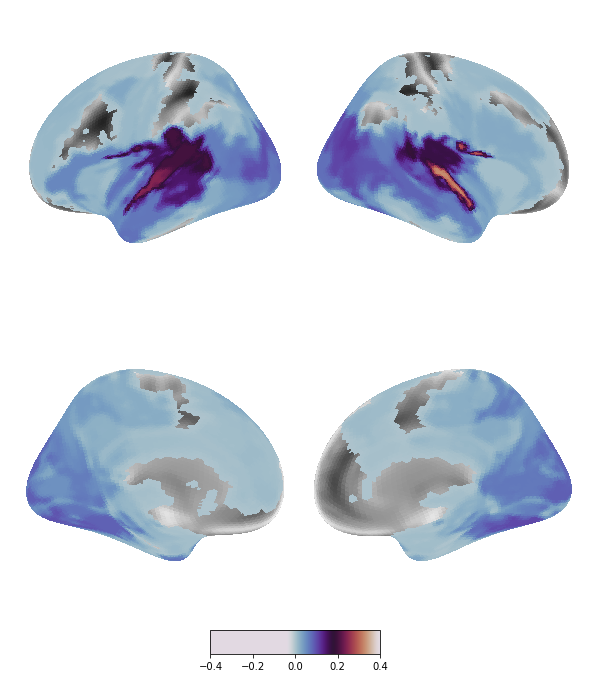

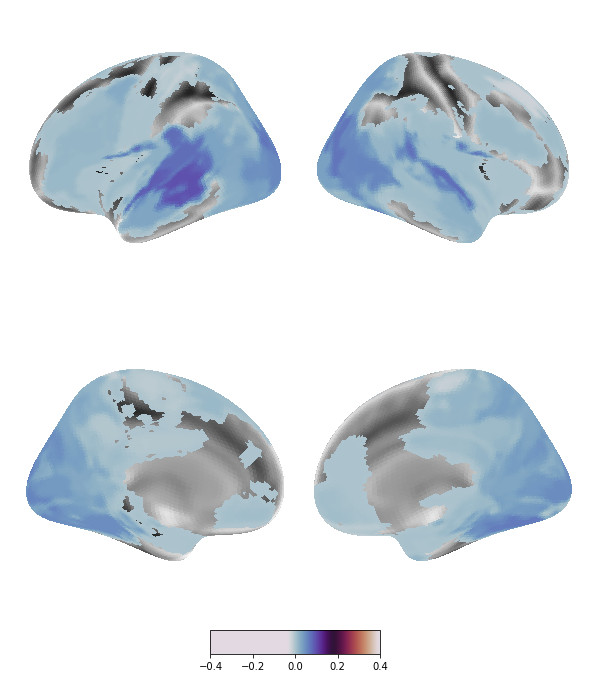

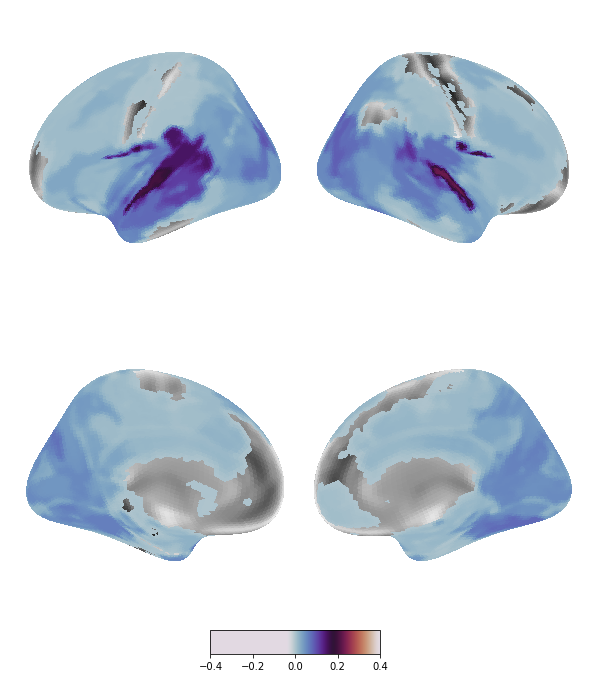

In [55]:
#fig_brain = plt.figure(figsize=(7,10))
#spec = fig_brain.add_gridspec(ncols=1, nrows=1)
#ax_brain = fig_brain.add_subplot(spec[0, 0])
#legend_ax = fig.add_subplot(spec[0, 1:])

#z=36
#cut_x = [18,20,78,80]
#brain_with_cuts(axe='axial', axe_slice=z, cut_x=cut_x, ax=ax_brain)
#ax_brain.set_axis_off()
#fig_brain.savefig(os.path.join(out_path, 'brain_cuts_STG.jpg'), dpi=100)
cmp = extend_colormap('twilight', percent_start=0.45, percent_finish=0)
mean_data = np.array([]).reshape(1,-1)

for sub in subs :  
    
    print(sub)
    
    #r² scores for each run of Friends S4
    run_conv_file_path = get_specific_file_path(r2_by_run_path, (sub, True),(scale, True),(conv, True))
    run_baseline_file_path = get_specific_file_path(r2_by_run_path, (sub, True),(scale, True),('_f_', False))
    run_null_file_path = get_specific_file_path(r2_by_run_path, (sub, True),(scale, True),(null_model, True))
    
    run_conv_data = np.load(run_conv_file_path)
    run_baseline_data = np.load(run_baseline_file_path) 
    run_null_data = np.load(run_null_file_path)
    
    #r² score from test after training
    test_path = os.path.join(r2_test_model_path, sub)
    
    test_conv_file_path = get_specific_file_path(test_path,(scale, True),(conv, True))
    test_conv_data = load(test_conv_file_path, map_location=device('cpu'))['test_r2']
    
    test_baseline_file_path = get_specific_file_path(test_path,(scale, True),('_f_', False))
    test_baseline_data = load(test_baseline_file_path, map_location=device('cpu'))['test_r2']
    
    diff_conv_bas_data = test_conv_data - test_baseline_data
    
    #------------------change args !!!--------------
    #statistical tests
    sign_region = stats_between_pop(run_baseline_data.T, run_null_data.T, test = wilcoxon, 
                                    threshold=0.05, difference = True)
    print(len(sign_region))
    
    #keep only roi with significative differences (others are set at 0)    
    idx_sign_roi = [idx for idx, p_value in sign_region]
    #run_conv_mean = np.mean(run_conv_data, axis=0)
    #sign_run_conv_mean = np.array([value if i in idx_sign_roi else 0 for i, value in enumerate(run_conv_mean)]).reshape(1,-1)
    sign_test_data = np.array([value if i in idx_sign_roi else 0 for i, value in enumerate(test_baseline_data)]).reshape(1,-1)  

    #surface map
    threshold = 0.0001
    vmax = 0.4
    colorbar = True
    n = 7
    cut_coords = [-63, -57, 57, 63]
    output_file = os.path.join(out_path, 'sign_baseline_WB_{}_r2_map.png'.format(sub))
    
    #add your fig code 
    fig = surface_fig(sign_test_data, vmax=vmax, threshold=threshold, colorbar=colorbar, cmap=cmp) 
    fig.set_size_inches(8,10) #8,10
    fig.savefig(output_file, dpi=100)
    
    #surface maps
    
    #fig = voxel_map(sign_test_baseline_data, vmax = 0.5)
    #fig = surface_fig(sign_test_baseline_data, vmax=vmax, threshold=threshold, colorbar=colorbar) 
    #fig.set_size_inches(12,3) #8,10
    
    #stripplot with order of ROIs in WB maps
    
    #best_n_roi, best_runs = df_runs_from_n_best_roi(run_baseline_data, n=n)
    #striplot_with_median(data = best_runs, x= 'subject', y='r2', hue = 'roi', hue_order = best_n_roi, palette=colormap, ax=ax)

In [ ]:
for sub in subs :  
    print(sub)
    #r² score from test after training
    r2_path = r2_by_run_path
    df = pd.DataFrame(columns=['conv', 'r²'])
    
    roi_a = 152
    roi_b = 141 if sub == 'sub-05' else 153
    
    for conv in ['conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'conv6', 'conv7'] :
        r2_conv_file_path = get_specific_file_path(r2_path, (sub, True), (scale, True),(conv, True))
        r2_conv_data = np.load(r2_conv_file_path)
        
        #a = best_rois_in_MIST_array(r2_conv_data)
        
        df_conv = pd.DataFrame()
        df_conv['conv'] = [conv]*len(r2_conv_data) 
        df_conv[label_pd['label'].iloc[roi_a]] = r2_conv_data[:, roi_a]
        df_conv[label_pd['label'].iloc[roi_b]] = r2_conv_data[:, roi_b]
        df_conv['max r²'] = np.amax(r2_conv_data, axis=1)
        df_conv = df_conv.melt(id_vars='conv', var_name='roi', value_name='r²')
        df = df.append(df_conv)

    r2_baseline_file_path = get_specific_file_path(r2_path,(scale, True),('_f_', False))
    r2_baseline_data = np.load(r2_conv_file_path)
    df_baseline = pd.DataFrame()
    df_baseline['conv'] = ['no finetune']*len(r2_baseline_data)
    df_baseline[label_pd['label'].iloc[roi_a]] = r2_conv_data[:, roi_a]
    df_baseline[label_pd['label'].iloc[roi_b]] = r2_conv_data[:, roi_b]
    df_baseline['max r²'] = np.amax(r2_conv_data, axis=1)
    df_baseline = df_baseline.melt(id_vars='conv', var_name='roi', value_name='r²')
    df = df.append(df_baseline, ignore_index=True)

    fig, axe = plt.subplots(1,1)
    sns.lineplot(data=df, x = 'conv', y = 'r²', hue = 'roi', ax=axe)
    output_file = os.path.join(out_path, '{}_graph_finetune_r2_.png'.format(sub))
    fig.set_size_inches(5,3)
    fig.savefig(output_file, dpi=100)
    

In [ ]:
names = list(colormap.keys())
roi_labels = [row['label'] for i, row in label_pd.iterrows() if row['name'] in names]
roi_index = [i for i, row in label_pd.iterrows() if row['name'] in names]
colors = ['darkmagenta', 'palevioletred', 'mediumslateblue', 
          'gold', 'indianred', 'maroon', 'seagreen', 'seagreen',
         'darkblue', 'goldenrod', 'navajowhite', 'orange']

fsaverage = datasets.fetch_surf_fsaverage()
plotting.plot_surf_contours(fsaverage.infl_right, MIST_path, levels = roi_index,
                            labels=roi_labels, colors=colors, legend=True)
